## Importing Libraries

We will add every library only when it is needed

In [204]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from PIL import Image

import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

---

## Importing Data for Reading

We have two folders named (Images, Annotations)

Images Folder:
It contains only images, 7,393 images 

Annotations Folder:
It conatins two folders names (xmls, trimaps) and three files (trainval.txt, test,txt, list,text)

xmls is bounding boxes which is used for object detection

trimaps is segements which is used for image segmentation

the other three files explain the data and categorize them so the are used for classification 

We will use the three files now for our classification task then we will us trimaps for segmentation.

In [205]:
# Adding the path of the data of classification
base_path = r"C:\Users\omara\Downloads\Multiclass Classification & Semantic Segmentation of Pet Breeds\data\oxford-iiit-pet"  
images_dir = os.path.join(base_path, "images")
annotations_dir = os.path.join(base_path, "annotations")

# Reading the annotation files used for classification
trainval_file = os.path.join(annotations_dir, "trainval.txt")
test_file = os.path.join(annotations_dir, "test.txt")
list_file = os.path.join(annotations_dir, "list.txt")

---

## Understanding the Annotations Files in the Annotations Folder

In [206]:
# Function for reading annotation files
def read_annotation_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Remove any comment line in the file
    data_lines = [line.strip() for line in lines if not line.startswith('#')]
    
    # making the data dataframe to bmake it easy to be understood
    data = []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 4:  
            image_name = parts[0]
            class_id = int(parts[1])
            species = int(parts[2])  
            breed_id = int(parts[3])
            data.append({
                'image_name': image_name,
                'class_id': class_id,
                'species': species,
                'breed_id': breed_id
            })
    
    return pd.DataFrame(data)

In [207]:
# Loading the annotations
trainval_df = pd.DataFrame(read_annotation_file(trainval_file))
test_df = pd.DataFrame(read_annotation_file(test_file))
list_df = pd.DataFrame(read_annotation_file(list_file))

In [208]:
# Showing the shape of the dataset
print(f"Training & Validation dataset size: {len(trainval_df)}")
print(f"Test dataset size: {len(test_df)}")
print(f"Total dataset size: {len(list_df)}")

Training & Validation dataset size: 3680
Test dataset size: 3669
Total dataset size: 7349


In [209]:
num_of_test_samples = 1000

# Randomly selecting 1000 test samples without losing order
test_samples = test_df.sample(n=num_of_test_samples, random_state=42)

# Getting the remaining images
taken_samples = test_df.drop(test_samples.index)  

# Appending taken samples to trainval dataset withouy losing order
trainval_df = pd.concat([trainval_df, taken_samples], ignore_index=True)

# Making new test datser
test_df = test_samples

In [210]:
# Showing the new shape of the dataset
print(f"Training & Validation dataset size after modification: {len(trainval_df)}")
print(f"Test dataset size after modification: {len(test_df)}")
print(f"Total dataset size after modification: {len(list_df)}")

Training & Validation dataset size after modification: 6349
Test dataset size after modification: 1000
Total dataset size after modification: 7349


In [211]:
# Showing the training dataset overview
print("Training dataset sample:")
trainval_df.head()

Training dataset sample:


,image_name,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [212]:
# Showing the testing dataset overview
print("Training dataset sample:")
test_df.head()

Training dataset sample:


,image_name,class_id,species,breed_id
179,american_bulldog_82,2,2,1
2679,Ragdoll_99,27,1,9
3133,shiba_inu_58,32,2,22
1061,chihuahua_79,11,2,6
1091,Egyptian_Mau_207,12,1,6


In [213]:
# Showing the species distribution in training data
print("Species distribution:")
trainval_df['species'].value_counts()
# 1 for cats 2 for dogs

Species distribution:


2    4300
1    2049
Name: species, dtype: int64

In [214]:
# Showing the species distribution in testing data
print("Species distribution:")
test_df['species'].value_counts()
# 1 for cats 2 for dogs

Species distribution:


2    678
1    322
Name: species, dtype: int64

In [ ]:
# Showing the species distribution in main data
print("Species distribution:")
list_df['species'].value_counts()  
# 1 for cats 2 for dogs 

Species distribution:


2    4978
1    2371
Name: species, dtype: int64

In [215]:
# Showing the number of breeds for eachg specie in training data to make sure of balancing
unique_breeds_per_specie = trainval_df.groupby("species")["breed_id"].nunique()
unique_breeds_per_specie

species
1    12
2    25
Name: breed_id, dtype: int64

In [216]:
# Showing the number of breeds for eachg specie in testing data to make sure of balancing
unique_breeds_per_specie = test_df.groupby("species")["breed_id"].nunique()
unique_breeds_per_specie

species
1    12
2    25
Name: breed_id, dtype: int64

In [ ]:
# Showing the number of breeds for eachg specie in main data to make sure of balancing
unique_breeds_per_specie = list_df.groupby("species")["breed_id"].nunique()
unique_breeds_per_specie

species
1    12
2    25
Name: breed_id, dtype: int64

In [218]:
# Showing the breed distribution of cats and dogs in training data
print("Breed distribution:")
trainval_df['breed_id'].value_counts().sort_index()

Breed distribution:


1     338
2     332
3     350
4     333
5     345
6     327
7     351
8     349
9     344
10    355
11    336
12    344
13    169
14    166
15    172
16    166
17    172
18    180
19    175
20    177
21    173
22    176
23    170
24    176
25    173
Name: breed_id, dtype: int64

In [219]:
# Showing the breed distribution of cats and dogs in testing data
print("Breed distribution:")
test_df['breed_id'].value_counts().sort_index()

Breed distribution:


1     60
2     68
3     50
4     51
5     54
6     63
7     45
8     51
9     56
10    45
11    63
12    56
13    30
14    34
15    28
16    30
17    28
18    20
19    25
20    23
21    26
22    24
23    19
24    24
25    27
Name: breed_id, dtype: int64

In [220]:
# Showing the breed distribution of cats and dogs in main data
print("Breed distribution:")
list_df['breed_id'].value_counts().sort_index()

Breed distribution:


1     398
2     400
3     400
4     384
5     399
6     390
7     396
8     400
9     400
10    400
11    399
12    400
13    199
14    200
15    200
16    196
17    200
18    200
19    200
20    200
21    199
22    200
23    189
24    200
25    200
Name: breed_id, dtype: int64

---

## Visualizing the data in the Annotations Files

In [221]:
# Extracting the name without the number and avoid many different underscores in ther name
def extracting_breed_name(image_name):
    match = re.match(r"(.+)_\d+$", image_name)
    return match.group(1) if match else image_name 

In [222]:
# Add breed name column to the dataframe
list_df['breed_name'] = list_df['image_name'].apply(extracting_breed_name)

In [223]:
# Counting the number of images per breed
breed_counts = list_df['breed_name'].value_counts()

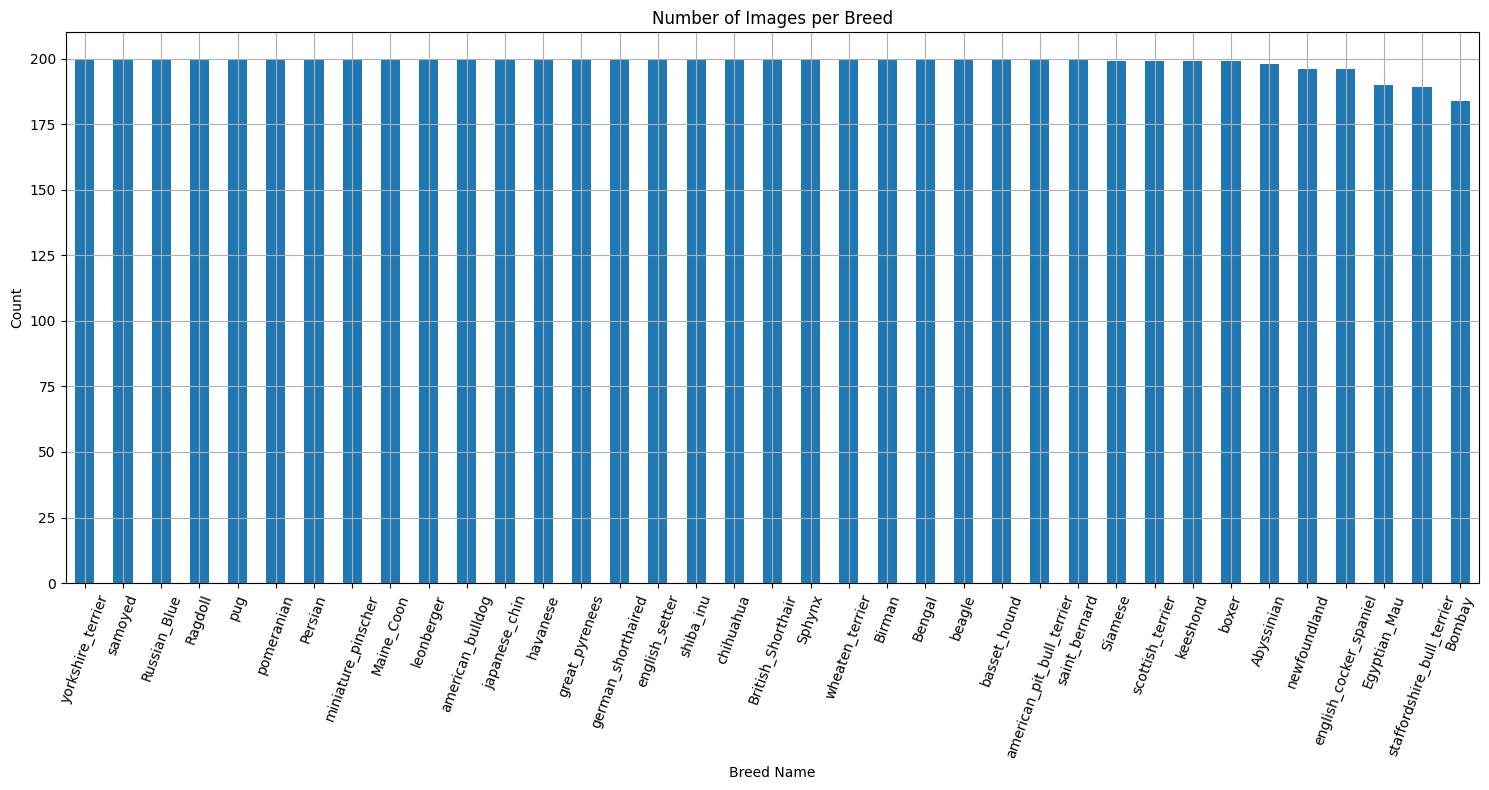

In [224]:
# Plotting the distribution of images per breed
plt.figure(figsize=(15, 8))
breed_counts.plot(kind='bar')
plt.title('Number of Images per Breed')
plt.xlabel('Breed Name')
plt.ylabel('Count')
plt.xticks(rotation=70)
plt.tight_layout()
plt.grid()
plt.show()

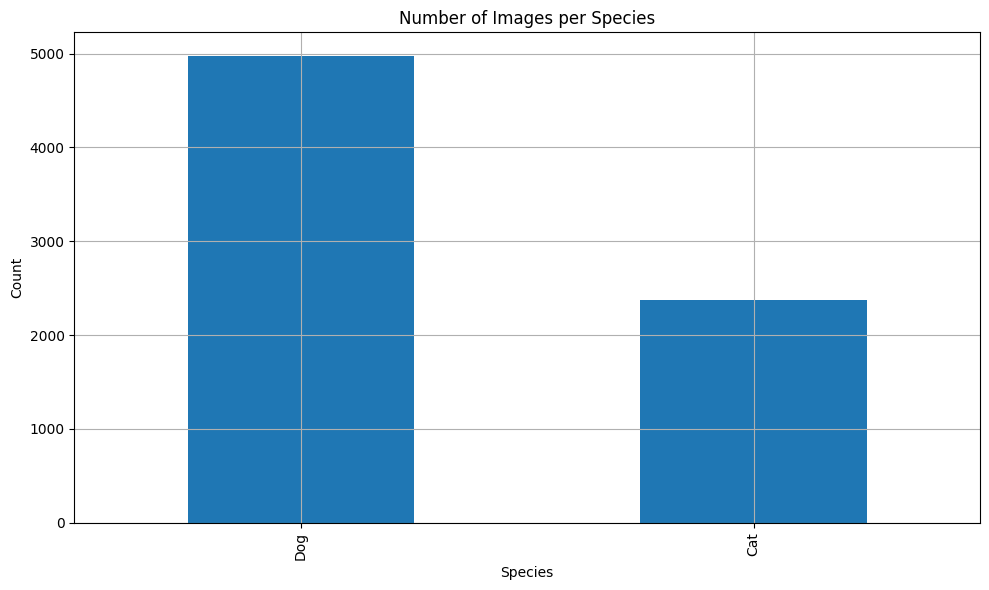

In [225]:
# Plotting the number of images per specie
species_counts = list_df['species'].value_counts()
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar')
plt.title('Number of Images per Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks([0, 1], ['Dog', 'Cat'])
plt.tight_layout()
plt.grid()
plt.show()

---

# Recap for the Annotations Data

- There are 2 species .. Cats & Dogs

- Cats contains 12 different breed

- Dogs contains 25 different breed

- There are total 37 breed

- Each breed contains in range of 200 images

- There are 4978 images of dogs and images 2371 of cats

---

## Visualizing the Images in the Images Folder

In [226]:
# Making a list of all files in the folder
image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Extracting the extension of the images
extensions = {os.path.splitext(f)[1].lower() for f in image_files}

print("Images Extensions:", extensions)


Images Extensions: {'.mat', '.jpg'}


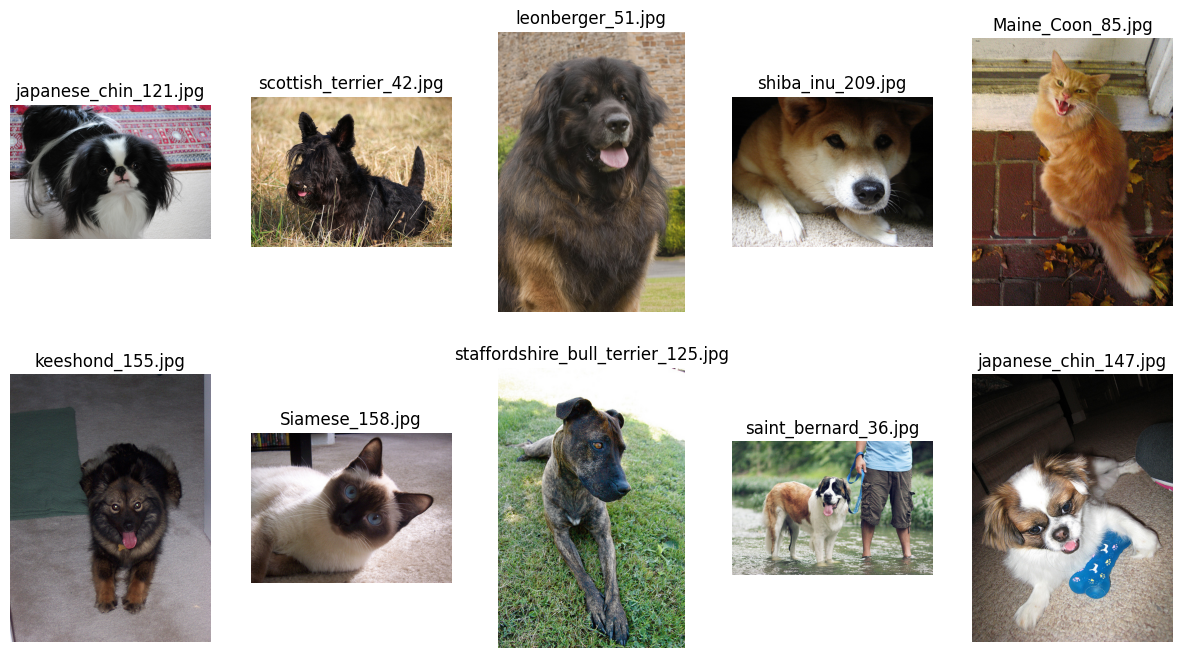

In [227]:
# Making a list of all files in the folder
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.mat', '.jpg'))]

# Selecting random images
random_images = random.sample(image_files, 10)

# Create subplots for images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Looping through the images and show them
for ax, image_file in zip(axes.flatten(), random_images):
    image_path = os.path.join(images_dir, image_file)
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')  
    ax.set_title(image_file)  

plt.show()



---

## Recap 

- The need libraries is imported

- The data is imported 

- The data is explained 

- Having insights from the data after visualizing it

---

## Preprocessing Images

- Resizing all images to a consistent size (224x224)
- Converting images to RGB format
- Normalizing pixels to the range [0, 1]
- Converting class IDs to zero-based indexing for model training

In [228]:
# Function to for preprocessing and attaching labels

# Parameters:
#        dataframe: DataFrame containing image information
#        images_dir: Directory containing the images
#        target_size: Size to resize images to
#        num_img: num of images for processing
    
# Returns:
#        X: Preprocessed images
#        y: Labels (class_id - 1 for zero-based indexing)
    
def preprocessing_images(dataframe, images_dir, target_size=(224, 224), num_img=32):

    num_samples = len(dataframe)
    x = np.zeros((num_samples, target_size[0], target_size[1], 3), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.int32)
    
    for i, (_, row) in enumerate(dataframe.iterrows()):

        image_name = row['image_name']
        image_path = os.path.join(images_dir, f"{image_name}.jpg")
        

        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            img = cv2.resize(img, target_size)
            img = preprocess_input(img)
            
            
            x[i] = img
            y[i] = row['class_id'] - 1  
        

        if (i + 1) % num_img == 0 or (i + 1) == num_samples:
            print(f"Processed {i + 1}/{num_samples} images", end='\r')
    
    print(f"\n{num_samples} images are completed")
    return x, y

In [229]:
# Make the Process
x_train, y_train = preprocessing_images(trainval_df, images_dir)
x_test, y_test = preprocessing_images(test_df, images_dir)

Processed 6349/6349 images
6349 images are completed
Processed 1000/1000 images
1000 images are completed


In [231]:
# Function for visualizing data after preprocessing 

#  Parameters:
#    x: Preprocessed images
#    y: Labels
#    class_names: List of class names
#    num_samples: Number of samples to visualize
def visualizing_preprocessed_images(x, y, class_names, num_samples=10):

    # Choosing random images
    indices = np.random.choice(len(x), min(num_samples, len(x)), replace=False)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    axes = axes.flatten()
    

    for i, idx in enumerate(indices):
      
        img = x[idx]
        label = y[idx]
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Creating a map from class ID to breed name used for visualizing
class_to_breed = {}
for _, row in list_df.iterrows():
    class_to_breed[row['class_id'] - 1] = extracting_breed_name(row['image_name'])

# Extracting unique class names
class_names = [class_to_breed.get(i, f"Unknown-{i}") for i in range(max(class_to_breed.keys()) + 1)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

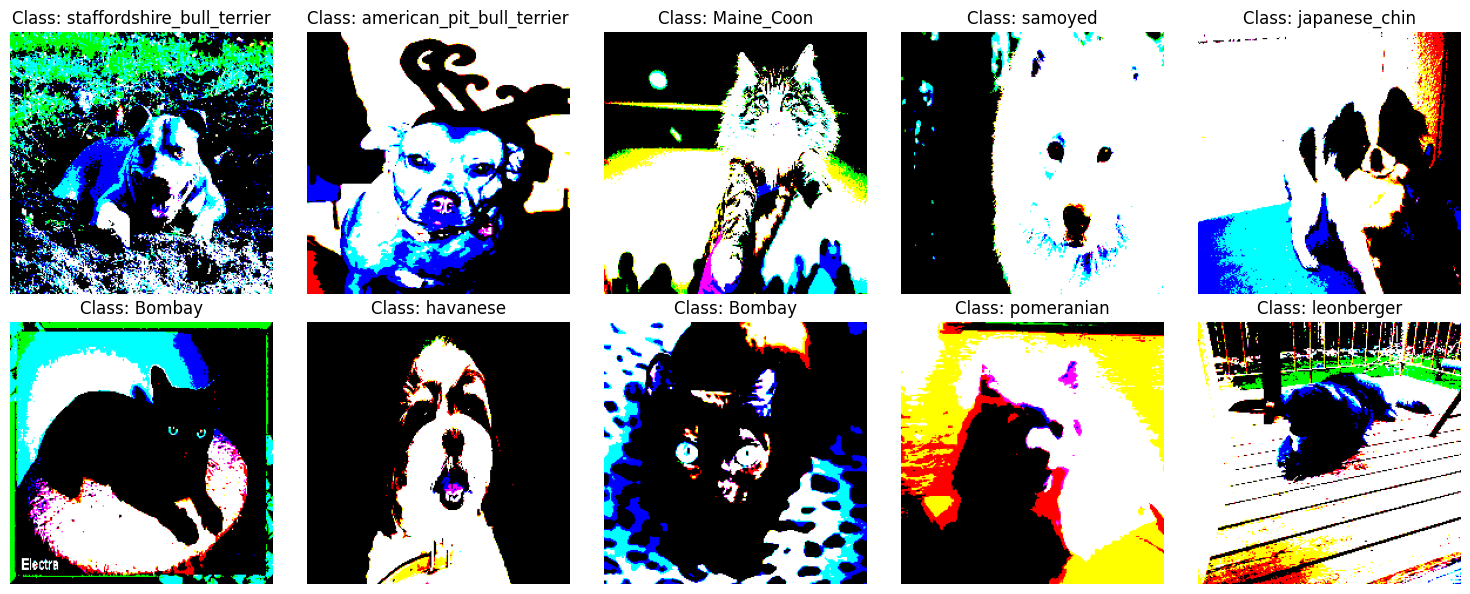

In [232]:
visualizing_preprocessed_images(x_train, y_train, class_names)

---

## Splitting the data to be ready for training

In [233]:
# Function for splitting the data
def split_dataset(x, y, test_size=0.2, random_state=42):
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

In [127]:
# Make the Process
x_train, x_val, y_train, y_val = split_dataset(x_train, y_train)

In [234]:
x_train.shape

(6349, 224, 224, 3)

In [235]:
x_val.shape

(736, 224, 224, 3)

In [236]:
x_test.shape

(1000, 224, 224, 3)

---

## Building the Model

In [237]:
# Create base model with pre-trained ResNet50 weights
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(37, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

---

In [238]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_checkpoints.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, early_stopping]

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) // 32,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.1616 - loss: 3.3423
Epoch 1: val_accuracy improved from -inf to 0.76772, saving model to best_checkpoints.h5

158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 483ms/step - accuracy: 0.1625 - loss: 3.3380 - val_accuracy: 0.7677 - val_loss: 1.0074
Epoch 2/15
  1/158 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.5000 - loss: 1.9007
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batc

---

# Making Predictions & Visualizing Training & Validation

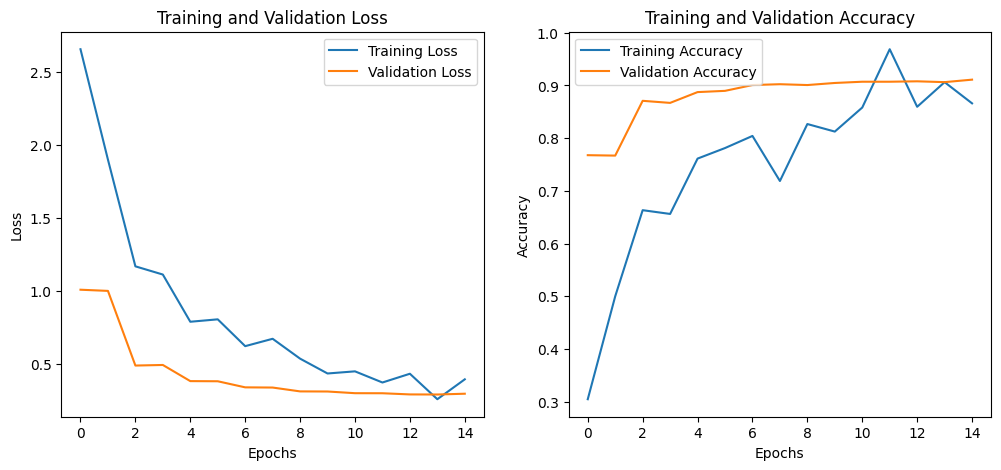

In [ ]:
# Plotting training and validation loss according to epochs
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Making predictions after training using validation
predictions_val = model.predict(x_val)

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step


In [ ]:
# converting predictions to classes
predictions_class_validation = np.argmax(predictions_val, axis=1)

In [ ]:
# Convert labels from numbers to names again
breed_name_mapping = dict(zip(list_df['class_id'], list_df['breed_name']))

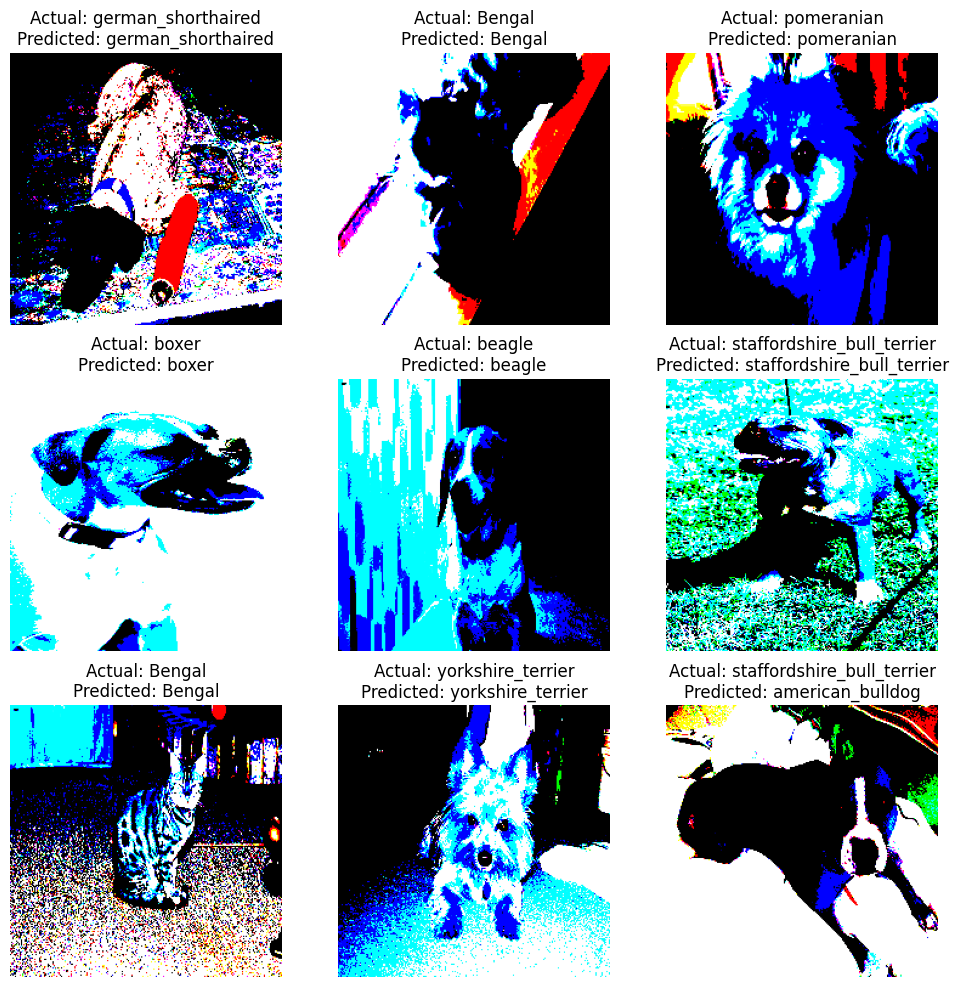

In [ ]:
# Visualizing the predictions with breed names
num_images_to_show = 9
plt.figure(figsize=(12, 12))

for i in range(min(num_images_to_show, len(x_val))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_val[i])

    actual_label_name = breed_name_mapping[y_val[i] + 1]
    predicted_label_name = breed_name_mapping[predictions_class_validation[i] + 1]

    plt.title(f"Actual: {actual_label_name}\nPredicted: {predicted_label_name}")
    plt.axis('off')

plt.show()

In [ ]:
# Printing classification report for validation
print("Classification Report:")
print(classification_report(y_val, predictions_class_validation))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        37
           1       0.80      0.89      0.85        37
           2       0.89      0.69      0.78        36
           3       0.91      0.97      0.94        32
           4       0.88      0.82      0.85        28
           5       0.93      0.82      0.87        45
           6       0.72      0.97      0.83        30
           7       0.97      0.97      0.97        32
           8       0.84      0.89      0.86        35
           9       0.96      0.69      0.81        39
          10       0.97      0.85      0.90        33
          11       0.87      0.87      0.87        31
          12       0.95      0.93      0.94        43
          13       0.93      0.93      0.93        30
          14       0.90      1.00      0.95        37
          15       0.97      0.97      0.97        33
          16       0.95      1.00      0.97        35
   

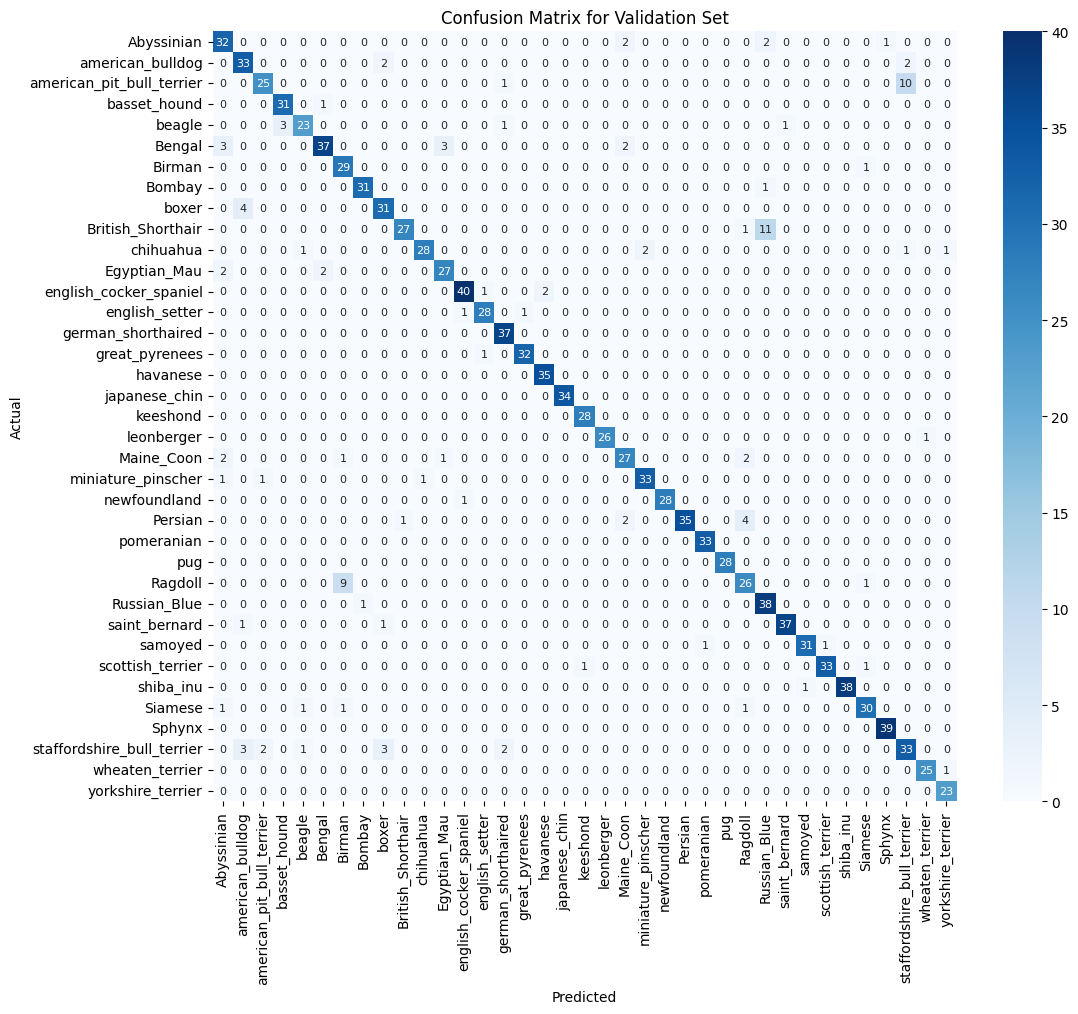

In [ ]:
# Correcting the indexing
breed_names = [breed_name_mapping[i + 1] for i in range(37)]

# Making confusion matrix for validation
cmValidation = confusion_matrix(y_val, predictions_class_validation)

# Visualizing confusion matrix with breed names
plt.figure(figsize=(12, 10))
sns.heatmap(cmValidation, annot=True, fmt='d', cmap='Blues', xticklabels=breed_names, yticklabels=breed_names, annot_kws={"size": 8})
plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Calculating misclassified samples
misclassified_idx = np.where(predictions_class_validation != y_val)[0]
misclassified_images = x_val[misclassified_idx]
misclassified_labels = y_val[misclassified_idx]
misclassified_preds = predictions_class_validation[misclassified_idx]

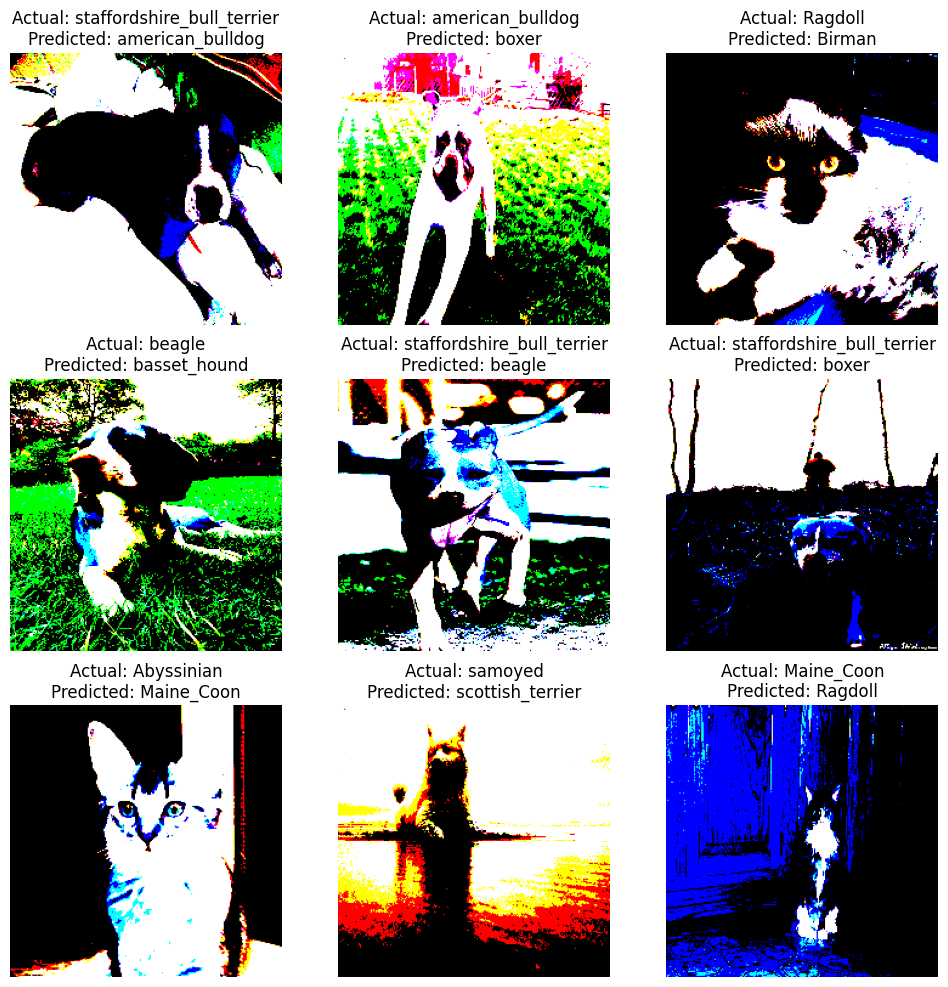

In [ ]:
# Visualizing misclassified images
plt.figure(figsize=(12, 12))
for i in range(min(9, len(misclassified_images))):

    plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i])

    actual_label_name = breed_name_mapping[misclassified_labels[i] + 1]
    perdicted_label_name = breed_name_mapping[misclassified_preds[i] + 1]

    plt.title(f"Actual: {actual_label_name}\nPredicted: {perdicted_label_name}")
    plt.axis('off')

plt.show()

---